# ViT Fine-tuning on CIFAR-10

Training mini_vit architecture on CIFAR-10 dataset.

In [22]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import numpy as np
import random
from tqdm import tqdm
import os

print(f"PyTorch version: {torch.__version__}")

PyTorch version: 2.9.1


## Hyperparameters

In [23]:
SEED = 0
BATCH_SIZE = 128
EPOCHS = 6
WARMUP_EPOCHS = 2
LEARNING_RATE = 0.002
WEIGHT_DECAY = 0.05
LABEL_SMOOTHING = 0.1

PATCH_SIZE = 4
IMG_SIZE = 32
NUM_CLASSES = 10
VIT_MLP_RATIO = 2
CHANNEL = 192
DEPTH = 9
HEADS = 6

torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

DEVICE = torch.device('cpu' if not torch.cuda.is_available() else 'cuda')
print(f"Device: {DEVICE}")

Device: cpu


## Data Loading

In [24]:
from torchvision.transforms import AutoAugment, AutoAugmentPolicy, RandomErasing
from torch.utils.data import Sampler

cifar_mean = (0.4914, 0.4822, 0.4465)
cifar_std = (0.2023, 0.1994, 0.2010)

train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(IMG_SIZE, padding=4),
    AutoAugment(policy=AutoAugmentPolicy.CIFAR10),
    transforms.ToTensor(),
    transforms.Normalize(mean=cifar_mean, std=cifar_std),
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=cifar_mean, std=cifar_std),
])

train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transform)

from torch.utils.data import random_split

train_loader = DataLoader(
    train_dataset, 
    batch_size=BATCH_SIZE, 
    num_workers=2,
    drop_last=True
)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

print(f"Test dataset size: {len(test_dataset)}")
print(f"Train batches: {len(train_loader)}")
print(f"Test batches: {len(test_loader)}")

Test dataset size: 10000
Train batches: 390
Test batches: 79


## Model

In [25]:
from src.models.mini_vit import MiniViT

model = MiniViT(
    img_size=IMG_SIZE,
    patch_size=PATCH_SIZE,
    n_classes=NUM_CLASSES,
    emb_dim=CHANNEL,
    n_layers=DEPTH,
    n_heads=HEADS,
    mlp_hidden_dim=CHANNEL * VIT_MLP_RATIO,
)

model.to(DEVICE)

num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Model: MiniViT")
print(f"Trainable parameters: {num_params:,}")
print(f"Image size: {IMG_SIZE}x{IMG_SIZE}")
print(f"Patch size: {PATCH_SIZE}")
print(f"Dim: {CHANNEL}")
print(f"Depth: {DEPTH}")
print(f"Heads: {HEADS}")
print(f"MLP ratio: {VIT_MLP_RATIO}")

Model: MiniViT
Trainable parameters: 2,674,762
Image size: 32x32
Patch size: 4
Dim: 192
Depth: 9
Heads: 6
MLP ratio: 2


## Loss, Optimizer, Scheduler

In [26]:
criterion = nn.CrossEntropyLoss(label_smoothing=LABEL_SMOOTHING)

optimizer = optim.AdamW(
    model.parameters(),
    lr=LEARNING_RATE,
    weight_decay=WEIGHT_DECAY,
)

total_steps = len(train_loader) * EPOCHS
warmup_steps = len(train_loader) * WARMUP_EPOCHS

class CosineAnnealingWithWarmup:
    def __init__(self, optimizer, warmup_steps, total_steps, lr):
        self.optimizer = optimizer
        self.warmup_steps = warmup_steps
        self.total_steps = total_steps
        self.lr = lr
        self.step_count = 0
    
    def step(self):
        self.step_count += 1
        
        if self.step_count < self.warmup_steps:
            lr = self.lr * (self.step_count / self.warmup_steps)
        else:
            progress = (self.step_count - self.warmup_steps) / (self.total_steps - self.warmup_steps)
            lr = self.lr * 0.5 * (1 + np.cos(np.pi * progress))
        
        for param_group in self.optimizer.param_groups:
            param_group['lr'] = lr
        
        return lr

scheduler = CosineAnnealingWithWarmup(optimizer, warmup_steps, total_steps, LEARNING_RATE)

print(f"Criterion: CrossEntropyLoss with label smoothing={LABEL_SMOOTHING}")
print(f"Optimizer: AdamW(lr={LEARNING_RATE}, wd={WEIGHT_DECAY})")
print(f"Scheduler: CosineAnnealingWithWarmup")
print(f"Total steps: {total_steps}")
print(f"Warmup steps: {warmup_steps}")

Criterion: CrossEntropyLoss with label smoothing=0.1
Optimizer: AdamW(lr=0.002, wd=0.05)
Scheduler: CosineAnnealingWithWarmup
Total steps: 2340
Warmup steps: 780


## Training Functions

In [27]:
def mixup_data(x, y, alpha=1.0):
    lam = np.random.beta(alpha, alpha) if alpha > 0 else 1
    batch_size = x.size(0)
    index = torch.randperm(batch_size).to(x.device)
    
    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    
    return mixed_x, y_a, y_b, lam

def cutmix_data(x, y, beta=1.0):
    lam = np.random.beta(beta, beta) if beta > 0 else 1
    batch_size = x.size(0)
    index = torch.randperm(batch_size).to(x.device)
    
    W = x.size(2)
    H = x.size(3)
    
    cut_ratio = np.sqrt(1.0 - lam)
    cut_h = int(H * cut_ratio)
    cut_w = int(W * cut_ratio)
    
    cx = np.random.randint(0, W)
    cy = np.random.randint(0, H)
    
    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)
    
    x[..., bby1:bby2, bbx1:bbx2] = x[index, :, bby1:bby2, bbx1:bbx2]
    
    lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1)) / (H * W)
    y_a, y_b = y, y[index]
    
    return x, y_a, y_b, lam

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

def train_one_epoch(epoch):
    model.train()
    total_loss = 0
    total_correct = 0
    total_samples = 0
    
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [Train]", leave=False)
    
    for images, targets in pbar:
        images = images.to(DEVICE)
        targets = targets.to(DEVICE)
        
        outputs = model(images)
        loss = criterion(outputs, targets)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        lr = scheduler.step()
        
        with torch.no_grad():
            _, pred = outputs.max(1)
            correct = pred.eq(targets).sum().item()
            total_correct += correct
            total_samples += targets.size(0)
            total_loss += loss.item() * targets.size(0)
        
        acc = 100.0 * correct / targets.size(0)
        pbar.set_postfix({'loss': f'{loss.item():.4f}', 'acc': f'{acc:.2f}%', 'lr': f'{lr:.6f}'})
    
    avg_loss = total_loss / total_samples
    avg_acc = 100.0 * total_correct / total_samples
    
    return avg_loss, avg_acc

def validate(loader):
    model.eval()
    total_loss = 0
    total_correct = 0
    total_samples = 0
    
    with torch.no_grad():
        for images, targets in loader:
            images = images.to(DEVICE)
            targets = targets.to(DEVICE)
            
            outputs = model(images)
            loss = criterion(outputs, targets)
            
            _, pred = outputs.max(1)
            correct = pred.eq(targets).sum().item()
            
            total_loss += loss.item() * targets.size(0)
            total_correct += correct
            total_samples += targets.size(0)
    
    avg_loss = total_loss / total_samples
    avg_acc = 100.0 * total_correct / total_samples
    
    return avg_loss, avg_acc

print("Training functions ready")

Training functions ready


## Training Loop

In [28]:
os.makedirs('checkpoints', exist_ok=True)

best_acc = 0
eval_interval = 2

train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

for epoch in range(EPOCHS):
    train_loss, train_acc = train_one_epoch(epoch)
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    val_loss, val_acc = validate(test_loader)
    
    if (epoch + 1) % eval_interval == 0 or epoch == EPOCHS - 1:
        test_losses.append(val_loss)
        test_accuracies.append(val_acc)
        
        print(f"Epoch {epoch+1:3d}/{EPOCHS} | "
            f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% | "
            f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")
        
        if val_acc > best_acc:
            best_acc = val_acc
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'best_acc': best_acc,
            }, 'checkpoints/best.pt')
            print(f"Best model saved! Accuracy: {best_acc:.2f}%")

print(f"\nTraining completed! Best accuracy: {best_acc:.2f}%")

test_loss, test_acc = validate(test_loader)
print(f"Final Test Accuracy: {test_acc:.2f}%")

Epoch 1/6 [Train]:   0%|          | 0/390 [00:00<?, ?it/s]

Attention output shape: torch.Size([128, 65, 192])
Attention output shape: torch.Size([128, 65, 192])
Attention output shape: torch.Size([128, 65, 192])
Attention output shape: torch.Size([128, 65, 192])
Attention output shape: torch.Size([128, 65, 192])
Attention output shape: torch.Size([128, 65, 192])
Attention output shape: torch.Size([128, 65, 192])
Attention output shape: torch.Size([128, 65, 192])
Attention output shape: torch.Size([128, 65, 192])


Epoch   2/6 | Train Loss: 1.9034 | Train Acc: 34.41% | Val Loss: 1.7428 | Val Acc: 42.78%
Best model saved! Accuracy: 42.78%


Epoch   4/6 | Train Loss: 1.7933 | Train Acc: 39.82% | Val Loss: 1.5472 | Val Acc: 51.72%
Best model saved! Accuracy: 51.72%


Epoch   6/6 | Train Loss: 1.6267 | Train Acc: 47.72% | Val Loss: 1.4133 | Val Acc: 57.70%
Best model saved! Accuracy: 57.70%

Training completed! Best accuracy: 57.70%
Final Test Accuracy: 57.70%


In [29]:
import matplotlib.pyplot as plt
def plot_metrics(train_losses, test_losses, train_accuracies, test_accuracies):
    train_epochs = range(1, len(train_losses) + 1)
    test_epochs = range(eval_interval, len(test_losses) * eval_interval + 1, eval_interval)
    
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(train_epochs, train_losses, label='Train Loss')
    plt.plot(test_epochs, test_losses, label='Test Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss over Epochs')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(train_epochs, train_accuracies, label='Train Accuracy')
    plt.plot(test_epochs, test_accuracies, label='Test Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.title('Accuracy over Epochs')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

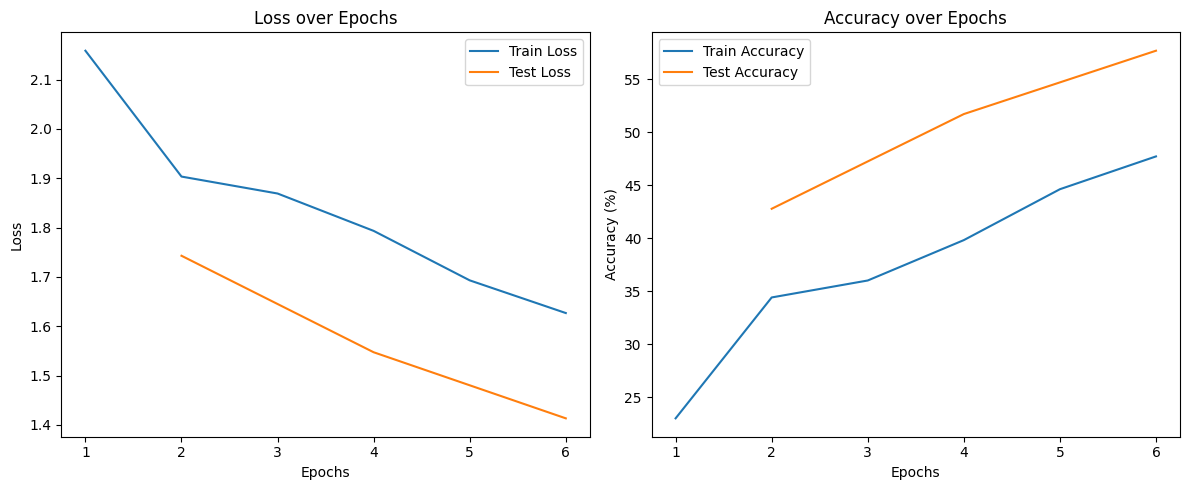

In [30]:
plot_metrics(train_losses, test_losses, train_accuracies, test_accuracies)